# Data Preprocessing Stage 2

## Overview

The previously cleaned up data set now containing file locations for BED and Fasta files will be processed so that the start and stop information of UTR and CDS regions and also the transcript will be in the dataframe.

Then the coding region is sanity checked for propper start and stop codons as well as correct triplet count.

In the process of doing this a couple of additional clean up steps needed to be undertaken.

The intermediate dataframe containing Transcript ID, PTR values, region details and transcript is saved as *preproc_stage2.csv*.

Furthermore there is a more detailed analysis of the PTR value distribution and sequence lengths.

In [39]:
# library dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import re
import matplotlib.pyplot as plt

In [2]:
# raw data file and path
datafile = '../data/preproc_stage1.csv'

# sanity check if the file exists
if not Path(datafile).is_file():
    print('Data file not found!')

In [3]:
# reading the data into a dataframe and looking at the first entries
df = pd.read_csv(datafile)
df

,EnsemblTranscriptID,Adrenal_PTR,Appendices_PTR,Brain_PTR,Colon_PTR,Duodenum_PTR,Endometrium_PTR,Esophagus_PTR,Fallopiantube_PTR,Fat_PTR,...,Spleen_PTR,Stomach_PTR,Testis_PTR,Thyroid_PTR,Tonsil_PTR,Urinarybladder_PTR,bed_files,fa_files,bed,fa
0,ENST00000263100,NA,8.277,NA,NA,NA,NA,NA,7.841,NA,...,7.313,NA,NA,NA,NA,NA,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...
1,ENST00000373993,NA,NA,NA,5.135,5.371,NA,NA,NA,NA,...,NA,5.8143,NA,NA,NA,NA,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...
2,ENST00000318602,6.290,6.328,5.948,5.811,6.068,5.383,5.881,6.119,6.410,...,5.136,6.5349,5.820,6.060,5.675,5.8286,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...
3,ENST00000299698,NA,NA,3.995,NA,NA,NA,4.129,NA,NA,...,NA,NA,2.350,NA,5.249,NA,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...
4,ENST00000401850,3.843,4.601,NA,NA,NA,NA,4.013,3.683,NA,...,NA,4.0613,4.832,NA,NA,4.2430,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11560,ENST00000374888,NA,NA,NA,NA,NA,NA,NA,NA,NA,...,NA,NA,NA,NA,4.681,NA,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...
11561,ENST00000294353,4.461,5.013,5.047,4.566,5.184,4.826,5.102,4.670,5.756,...,4.255,4.0412,5.389,4.250,4.439,4.1460,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...
11562,ENST00000322764,5.664,5.524,5.478,5.915,5.811,5.817,5.943,5.509,4.931,...,6.159,5.8846,5.582,5.598,5.968,5.3358,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...
11563,ENST00000381638,5.112,4.918,5.139,5.190,5.442,5.602,4.715,4.956,5.033,...,5.110,5.0834,5.047,5.038,5.130,5.0619,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...


In [4]:
# convert all 'NA' entries to np.NaN for easier handling
df.replace(regex=r'.*NA$', value=np.NaN, inplace=True)

In [5]:
# check if any BED files are missing (assuming that there is always a corresponding Fasta file - which there is)
df['bed'].isnull().sum()

0

## Extracting BED file data

These files contain details where the UTR and CDS start and stop.

In [6]:
# read BED files and store info in df

# BED file structure
# ENST00000000233.10	0	88	5UTR	.	+
# ENST00000000233.10	88	631	CDS	.	+
# ENST00000000233.10	631	1032	3UTR	.	+

# new dataframe columns
df['5UTR start'] = None
df['5UTR stop'] = None
df['CDS start'] = None
df['CDS stop'] = None
df['3UTR start'] = None
df['3UTR stop'] = None

def read_BED(file):
    # sanity check
    if not file.exists():
        print(tid, 'BED file does not exist!', file)
        return (-1, -1, -1, -1. -1, -1, -1)

    UTR5_start = UTR5_stop = UTR3_start = UTR3_stop = -1
    linecount = 0

    # read the file, extract UTR and CDS information and store it in the dataframe
    with file.open() as f:
        for line in f:
            data = line.split('\t')
            if len(data) != 6:
                print(tid, 'BED data column missing.', file)
                break
            if data[3] == '5UTR':
                UTR5_start = data[1]
                UTR5_stop = data[2]
            elif data[3] == 'CDS':
                CDS_start = data[1]
                CDS_stop = data[2]
            elif data[3] == '3UTR':
                UTR3_start = data[1]
                UTR3_stop = data[2]
            else:
                print(tid, 'Unknown transcript region.', file)
                break
            linecount += 1

    return (linecount, UTR5_start, UTR5_stop, CDS_start, CDS_stop, UTR3_start, UTR3_stop)

# loop over all transcript IDs
for tid in df['EnsemblTranscriptID']:
    # get BED file name
    bed_file = Path(df.loc[df['EnsemblTranscriptID'] == tid, 'bed'].values[0])

    linecount, UTR5_start, UTR5_stop, CDS_start, CDS_stop, UTR3_start, UTR3_stop = read_BED(bed_file)

    # update the dataframe
    df.loc[ df['EnsemblTranscriptID'] == tid, '5UTR start'] = UTR5_start
    df.loc[ df['EnsemblTranscriptID'] == tid, '5UTR stop'] = UTR5_stop
    df.loc[ df['EnsemblTranscriptID'] == tid, 'CDS start'] = CDS_start
    df.loc[ df['EnsemblTranscriptID'] == tid, 'CDS stop'] = CDS_stop
    df.loc[ df['EnsemblTranscriptID'] == tid, '3UTR start'] = UTR3_start
    df.loc[ df['EnsemblTranscriptID'] == tid, '3UTR stop'] = UTR3_stop

    if linecount != 3:
        print(tid, 'BED line count off.', bed_file)

ENST00000360265 BED line count off. ../../GENCODE43/protein_coding/BED6__protein_coding_strict/ENST00000360265.9.bed
ENST00000439040 BED line count off. ../../GENCODE43/protein_coding/BED6__protein_coding_strict/ENST00000439040.6.bed
ENST00000369733 BED line count off. ../../GENCODE43/protein_coding/BED6__protein_coding_strict/ENST00000369733.8.bed
ENST00000612273 BED line count off. ../../GENCODE43/protein_coding/BED6__protein_coding_strict/ENST00000612273.2.bed
ENST00000452319 BED line count off. ../../GENCODE43/protein_coding/BED6__protein_coding_strict/ENST00000452319.6.bed
ENST00000468623 BED line count off. ../../GENCODE43/protein_coding/BED6__protein_coding_strict/ENST00000468623.6.bed
ENST00000602569 BED line count off. ../../GENCODE43/protein_coding/BED6__protein_coding_strict/ENST00000602569.2.bed
ENST00000612619 BED line count off. ../../GENCODE43/protein_coding/BED6__protein_coding_strict/ENST00000612619.2.bed
ENST00000298622 BED line count off. ../../GENCODE43/protein_codi

Manual inspection of the above metioned BED files shows that not all transcripts have both UTR regions included.

In [7]:
# convert data types (was necessary because the comparison below failed othewise)
df['5UTR start'] = df['5UTR start'].astype(int)
df['5UTR stop'] = df['5UTR stop'].astype(int)
df['CDS start'] = df['CDS start'].astype(int)
df['CDS stop'] = df['CDS stop'].astype(int)
df['3UTR start'] = df['3UTR start'].astype(int)
df['3UTR stop'] = df['3UTR stop'].astype(int)

In [8]:
# show what the amended dataframe looks like
df

,EnsemblTranscriptID,Adrenal_PTR,Appendices_PTR,Brain_PTR,Colon_PTR,Duodenum_PTR,Endometrium_PTR,Esophagus_PTR,Fallopiantube_PTR,Fat_PTR,...,bed_files,fa_files,bed,fa,5UTR start,5UTR stop,CDS start,CDS stop,3UTR start,3UTR stop
0,ENST00000263100,NaN,8.277,NaN,NaN,NaN,NaN,NaN,7.841,NaN,...,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...,0,55,55,1543,1543,3382
1,ENST00000373993,NaN,NaN,NaN,5.135,5.371,NaN,NaN,NaN,NaN,...,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...,0,92,92,1877,1877,2044
2,ENST00000318602,6.290,6.328,5.948,5.811,6.068,5.383,5.881,6.119,6.410,...,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...,0,70,70,4495,4495,4610
3,ENST00000299698,NaN,NaN,3.995,NaN,NaN,NaN,4.129,NaN,NaN,...,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...,0,31,31,4396,4396,5127
4,ENST00000401850,3.843,4.601,NaN,NaN,NaN,NaN,4.013,3.683,NaN,...,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...,0,490,490,1552,1552,2321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11560,ENST00000374888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...,0,38,38,2450,2450,5467
11561,ENST00000294353,4.461,5.013,5.047,4.566,5.184,4.826,5.102,4.670,5.756,...,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...,0,201,201,2436,2436,8143
11562,ENST00000322764,5.664,5.524,5.478,5.915,5.811,5.817,5.943,5.509,4.931,...,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...,0,80,80,1799,1799,2228
11563,ENST00000381638,5.112,4.918,5.139,5.190,5.442,5.602,4.715,4.956,5.033,...,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...,0,135,135,9021,9021,11466


The 17 files listed above where the expected line count in the BED file was off is just transcripts without UTRs.

In [9]:
# extract only the entries without UTR
df[ (df['5UTR start'] == -1) | (df['3UTR start'] == -1) ]

,EnsemblTranscriptID,Adrenal_PTR,Appendices_PTR,Brain_PTR,Colon_PTR,Duodenum_PTR,Endometrium_PTR,Esophagus_PTR,Fallopiantube_PTR,Fat_PTR,...,bed_files,fa_files,bed,fa,5UTR start,5UTR stop,CDS start,CDS stop,3UTR start,3UTR stop
286,ENST00000360265,4.511,3.539,4.331,4.450,4.362,5.159,4.521,4.855,5.139,...,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...,-1,-1,0,2193,2193,7244
851,ENST00000439040,4.067,2.584,3.836,3.046,4.028,4.073,4.007,4.017,1.683,...,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...,0,404,404,4085,-1,-1
2195,ENST00000369733,NaN,NaN,NaN,3.304,2.696,NaN,3.075,NaN,NaN,...,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...,-1,-1,0,4248,4248,5197
2217,ENST00000612273,6.559,6.092,5.206,7.293,6.509,6.288,6.682,7.069,6.243,...,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...,-1,-1,0,1351,1351,1531
4099,ENST00000452319,NaN,NaN,NaN,NaN,NaN,4.021,NaN,NaN,NaN,...,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...,-1,-1,0,4761,-1,-1
4158,ENST00000468623,5.960,4.974,6.611,6.144,6.065,5.607,5.679,5.745,5.531,...,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...,-1,-1,0,984,-1,-1
4723,ENST00000602569,NaN,NaN,NaN,NaN,4.319,3.581,NaN,NaN,3.887,...,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...,-1,-1,0,435,435,556
4780,ENST00000612619,3.805,3.872,3.140,NaN,NaN,NaN,3.389,3.696,NaN,...,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...,-1,-1,0,2499,-1,-1
4976,ENST00000298622,NaN,NaN,4.842,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...,-1,-1,0,2535,2535,6493
5128,ENST00000370378,5.685,NaN,5.136,5.434,NaN,5.372,5.103,4.156,5.228,...,1,1,../../GENCODE43/protein_coding/BED6__protein_c...,../../GENCODE43/protein_coding/FA_protein_codi...,-1,-1,0,4230,4230,4622


## Extracting Fasta File Data

Retrieving the base pair sequence from the corresponding Fasta file.

In [10]:
# read Fasta files and store information in dataframe

df['transcript'] = ''

def read_FA(file, tid):
    # sanity check
    if not file.exists():
        print(tid, 'Fasta file does not exist!', file)
        return (-1, '')

    # read the file, extract UTR and CDS information and store it in the dataframe
    with file.open() as f:
        # read the first line which should contain a label
        label = f.readline()
        # match the transcript ID and transcript length
        m = re.match(r'>' + tid + r'\.\d+:0-(?P<trans_length>\d+)', label)
        if not m:
            print(tid, 'Fasta file format error.', file)
            return (-1, '')
        # store the max transcript length
        length = int(m.group('trans_length'))

        # read the second line which is the transcript
        transcript = f.readline()

    return (length, transcript)

maxlength = 0

# loop over all transcript IDs
for tid in df['EnsemblTranscriptID']:
    # get BED file name
    fa_file = Path(df.loc[df['EnsemblTranscriptID'] == tid, 'fa'].values[0])

    length, transcript = read_FA(fa_file, tid)

    if length > maxlength: maxlength = length

    # update dataframe
    df.loc[ df['EnsemblTranscriptID'] == tid, 'transcript'] = transcript

print('longest transcript is', maxlength, 'bp')

longest transcript is 109224 bp


In [11]:
# drop the count and file reference columns
df.drop(labels=['bed_files', 'fa_files', 'bed', 'fa'], axis=1, inplace=True)

In [12]:
# show the current dataframe
df

,EnsemblTranscriptID,Adrenal_PTR,Appendices_PTR,Brain_PTR,Colon_PTR,Duodenum_PTR,Endometrium_PTR,Esophagus_PTR,Fallopiantube_PTR,Fat_PTR,...,Thyroid_PTR,Tonsil_PTR,Urinarybladder_PTR,5UTR start,5UTR stop,CDS start,CDS stop,3UTR start,3UTR stop,transcript
0,ENST00000263100,NaN,8.277,NaN,NaN,NaN,NaN,NaN,7.841,NaN,...,NaN,NaN,NaN,0,55,55,1543,1543,3382,ATTGCTGCAGACGCTCACCCCAGACACTCACTGCACCGGAGTGAGC...
1,ENST00000373993,NaN,NaN,NaN,5.135,5.371,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0,92,92,1877,1877,2044,ATAATCAAGGAAACCTTTTCCGGGTGGGGATCTCTGAAATTACTCA...
2,ENST00000318602,6.290,6.328,5.948,5.811,6.068,5.383,5.881,6.119,6.410,...,6.060,5.675,5.8286,0,70,70,4495,4495,4610,GGGACCAGATGGATTGTAGGGAGTAGGGTACAATACAGTCTGTTCT...
3,ENST00000299698,NaN,NaN,3.995,NaN,NaN,NaN,4.129,NaN,NaN,...,NaN,5.249,NaN,0,31,31,4396,4396,5127,GACCCTGGAAAAATCTGTCTCACCCACAAAGATGTGGGCTCAGCTC...
4,ENST00000401850,3.843,4.601,NaN,NaN,NaN,NaN,4.013,3.683,NaN,...,NaN,NaN,4.2430,0,490,490,1552,1552,2321,TGCACTTCTGTGCCTCAATTTCCTCATCTGTAGGGTGGGGGTGGTG...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11560,ENST00000374888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4.681,NaN,0,38,38,2450,2450,5467,CTCGGCTCTGGTTCCAGCCGAGCCTCTCGGACGCAGAGATGGAAAT...
11561,ENST00000294353,4.461,5.013,5.047,4.566,5.184,4.826,5.102,4.670,5.756,...,4.250,4.439,4.1460,0,201,201,2436,2436,8143,GGAGTCTGCGCTCTGGTTCGGGCTGCGGCTGCGGCTGCGGCTGCGG...
11562,ENST00000322764,5.664,5.524,5.478,5.915,5.811,5.817,5.943,5.509,4.931,...,5.598,5.968,5.3358,0,80,80,1799,1799,2228,GCAGAGTCTGCGGACCCGGCGCCGAGGCGGCCACCCGAGACGCGGC...
11563,ENST00000381638,5.112,4.918,5.139,5.190,5.442,5.602,4.715,4.956,5.033,...,5.038,5.130,5.0619,0,135,135,9021,9021,11466,AGGAAGCCGGAAGCCGCAGGGGCCGCCGTCGTCTCCTCCGCGTCCC...


## Sanity Check Coding Region
- check for start codon (AUG, CUG)
- check for stop codon (UAA, UAG, UGA)
- check CDS length multiple of 3


In [13]:
def CDS_sanity_check():
    # lists of valid start and stop codons
    start_codons = [
        ['A', 'T', 'G'],
        ['C', 'T', 'G']
    ]
    
    stop_codons = [
        ['T', 'A', 'A'],
        ['T', 'A', 'G'],
        ['T', 'G', 'A']
    ]
    
    # number of problems
    error_count = 0
    
    # looping over all dataframe rows
    for index, row in df.iterrows():
        CDS_problem = False
    
        CDS_length = row['CDS stop'] - row['CDS start']
        if (CDS_length % 3) != 0:
            print(row['EnsemblTranscriptID'], 'CDS length is NOT a multiple of three!')
            CDS_problem = True
    
        CDS = list(row['transcript'])
        
        CDS_start_codon = CDS[row['CDS start']:row['CDS start']+3]
        CDS_stop_codon = CDS[row['CDS stop']-3:row['CDS stop']]
    
        if not CDS_start_codon in start_codons:
            print(row['EnsemblTranscriptID'], 'Start codon invalid!', CDS_start_codon)
            CDS_problem = True
    
        if not CDS_stop_codon in stop_codons:
            print(row['EnsemblTranscriptID'], 'Stop codon invalid!', CDS_stop_codon)
            CDS_problem = True
    
        if CDS_problem:
            error_count += 1
    
    print('\n', error_count, 'transcripts with problems have been found in the dataset')

In [14]:
# CDS sanity checks

CDS_sanity_check()

ENST00000308647 Stop codon invalid! ['C', 'G', 'C']
ENST00000612273 CDS length is NOT a multiple of three!
ENST00000612273 Start codon invalid! ['C', 'A', 'T']
ENST00000355630 Start codon invalid! ['G', 'T', 'G']
ENST00000368554 CDS length is NOT a multiple of three!
ENST00000368554 Start codon invalid! ['C', 'C', 'T']
ENST00000485079 CDS length is NOT a multiple of three!
ENST00000485079 Start codon invalid! ['G', 'A', 'A']
ENST00000485079 Stop codon invalid! ['A', 'A', 'A']
ENST00000414423 Start codon invalid! ['A', 'C', 'G']

 6 transcripts with problems have been found in the dataset


Manually checking the 6 results:
- *ENST00000308647* is protein coding but with problems and is not the canonical version any more. It's **ENST00000673477**.
- *ENST00000612273* is protein coding but with problems and is not the canonical version any more. It's **ENST00000361866**.
- *ENST00000355630* is annotated as non-ATG start. Meaning it's rare but still functional and **valid**.
- *ENST00000368554* is flagged as protein coding but as it has two errors it will be **removed** from the list.
- *ENST00000485079* is flagged as protein coding but as it has two errors it will be **removed** from the list.
- *ENST00000414423* is annotated as non-ATG start. Meaning it's rare but still functional and **valid**.

In [15]:
# manual updates to the dataframe

# the two transcripts with more up to date versions
def update_entry(tid_old, tid_new, bed_file, fa_file):
    # update BED data
    linecount, UTR5_start, UTR5_stop, CDS_start, CDS_stop, UTR3_start, UTR3_stop = read_BED(bed_file)

    df.loc[ df['EnsemblTranscriptID'] == tid_old, '5UTR start'] = int(UTR5_start)
    df.loc[ df['EnsemblTranscriptID'] == tid_old, '5UTR stop'] = int(UTR5_stop)
    df.loc[ df['EnsemblTranscriptID'] == tid_old, 'CDS start'] = int(CDS_start)
    df.loc[ df['EnsemblTranscriptID'] == tid_old, 'CDS stop'] = int(CDS_stop)
    df.loc[ df['EnsemblTranscriptID'] == tid_old, '3UTR start'] = int(UTR3_start)
    df.loc[ df['EnsemblTranscriptID'] == tid_old, '3UTR stop'] = int(UTR3_stop)

    if linecount != 3:
        print(tid_old, 'BED line count off.', bed_file)

    # update Fasta data
    length, transcript = read_FA(fa_file, tid_new)
    
    df.loc[ df['EnsemblTranscriptID'] == tid_old, 'transcript'] = transcript

    # update transcript ID
    df.loc[ df['EnsemblTranscriptID'] == tid_old, 'EnsemblTranscriptID'] = tid_new

bed_file = Path('../../GENCODE43/protein_coding/BED6__protein_coding_strict/ENST00000673477.1.bed')
fa_file = Path('../../GENCODE43/protein_coding/FA_protein_coding_strict_mRNA/ENST00000673477.1:0-4098.fasta')
update_entry('ENST00000308647', 'ENST00000673477', bed_file, fa_file)

bed_file = Path('../../GENCODE43/protein_coding/BED6__protein_coding_strict/ENST00000361866.8.bed')
fa_file = Path('../../GENCODE43/protein_coding/FA_protein_coding_strict_mRNA/ENST00000361866.8:0-4203.fasta')
update_entry('ENST00000612273', 'ENST00000361866', bed_file, fa_file)

# removing the two entries with multiple errors
df.drop(df[ df['EnsemblTranscriptID'] == 'ENST00000368554'].index, inplace=True)
df.drop(df[ df['EnsemblTranscriptID'] == 'ENST00000485079'].index, inplace=True)

In [16]:
# running the sanity check again
# there should only be two IDs listed that fail the checks but are OK

CDS_sanity_check()

ENST00000355630 Start codon invalid! ['G', 'T', 'G']
ENST00000414423 Start codon invalid! ['A', 'C', 'G']

 2 transcripts with problems have been found in the dataset


## Store DF as CSV

In [17]:
# write current pre processed table to file
datafile = '../data/preproc_stage2.csv'
df.to_csv(datafile, index=False)

## Further Analysis of the Raw Data

### Longest Sequence

In [18]:
# longest sequence
maxlength = 0
tid = ''

# looping over all dataframe rows
for index, row in df.iterrows():
    length = len(row['transcript'])
    if length > maxlength: 
        maxlength = length
        tid = row['EnsemblTranscriptID']

print('longest sequence (', tid, ') has', maxlength, 'bps')

longest sequence ( ENST00000589042 ) has 109225 bps


### Tissue with the most PTR values

In [42]:
# check which tissue column has the least NaN entries
# relevant for a MVP ML approach
s = df.isna().sum()
s[s > 0].sort_values()

Lung_PTR              2700
Testis_PTR            2931
Duodenum_PTR          2965
Smallintestine_PTR    2974
Fallopiantube_PTR     2988
Brain_PTR             3072
Stomach_PTR           3116
Adrenal_PTR           3155
Endometrium_PTR       3387
Colon_PTR             3388
Gallbladder_PTR       3400
Placenta_PTR          3455
Rectum_PTR            3464
Prostate_PTR          3556
Tonsil_PTR            3595
Smoothmuscle_PTR      3624
Salivarygland_PTR     3635
Esophagus_PTR         3651
Urinarybladder_PTR    3691
Liver_PTR             3717
Kidney_PTR            3752
Lymphnode_PTR         3894
Thyroid_PTR           3955
Appendices_PTR        4005
Spleen_PTR            4016
Ovary_PTR             4028
Pancreas_PTR          4054
Heart_PTR             4112
Fat_PTR               4269
dtype: int64

### A Closer Look at Sequence Lengths

In [74]:
# creating a df only with sequence lengths
df2 = df['transcript'].map(lambda x: len(x))

In [75]:
df2.mean()

3730.0007783447204

In [34]:
df2.max()

109225

In [35]:
df2.min()

304

In [36]:
df2.std()

2930.9225217184253

In [107]:
# finding sequences above a certain bp threshold
threshold = 10000
df[ df['transcript'].map(lambda x: len(x)) > threshold]['EnsemblTranscriptID'].count()

413

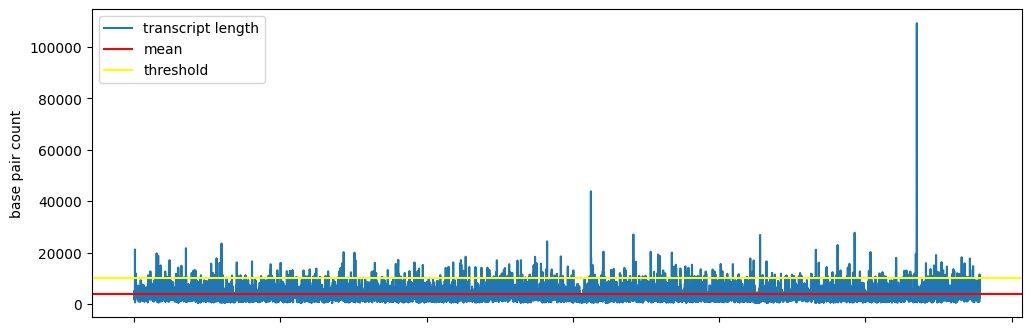

In [108]:
# overview of sequence lengths
fig, axs = plt.subplots(figsize=(12, 4))
axs.set_ylabel('base pair count')
axs.set_xticklabels([])
df2.plot()
plt.axhline(y=df2.mean(), color='red')
plt.axhline(y=threshold, color='yellow')
axs.legend(['transcript length', 'mean', 'threshold'])
plt.show()

The plot shows that there are two outliers in sequence length.

**It would be prudent to choose a threshold for sequence length for the ML approach.**

As all squence need padding to the longest it will produces a huge data overhead and might skew the anlysis too.

## Encoding

There are several approaches:
- A minimal viable project would be to train the network to predict only one selected tissue PTR value. A good choice is *lung*.
- Train the network for all tissues.
- Use multi hot encoding for the sequence + region + codon position and one hot encoding for the tissue.
- Do not use additional sequence annotations and use an embedding layer with byte-pair-encoding.


- one hot encode sequences
- one hot encode region
- one hot encode codon position
- combine into multi hot encoding
- store as X1

- encode tissue one hot
- store as X2

- related PTR as float
- store as y

- keep array positions synced!

## Save X* and Y as files


In [109]:
def hotenc(seq, u5_start=-1, u5_stop=-1, c_start=-1, c_stop=-1, u3_start=-1, u3_stop=-1, multi=True):
    """One or Multi Hot Encode the given base pair sequence
    Depending on the value of multi it either works as one hot encoding for just the sequence
    or multi hot encoding for sequence, region and codon position

    Keyword Arguments:
    seq -- string of base pairs (valid characters: ATGC)
    u5_start -- int, 5'UTR start position
    u5_stop -- int, 5'UTR stop position
    c_start -- int, CDS start position
    c_stop -- int, CDS stop position
    u3_start -- int, 3'UTR start position
    u3_stop -- int, 3'UTR stop position
    multi -- bool, selection between one hot encoding or multi hot encoding

    Returns:
    numpy ndarray of hot encoded sequence and additional information if wanted
    """    
    if multi: encoded_sequence = np.empty((len(seq),10), dtype=int)
    else: encoded_sequence = np.empty((len(seq),4), dtype=int)
    
    for idx, x in enumerate(seq):
        if multi: encoded = np.zeros((10,), dtype=int)
        else: encoded = np.zeros((4,), dtype=int)
        
        # one hot encoding the sequence
        mapping = { 'A' : 0, 'T' : 1, 'G' : 2, 'C' : 3 }
        encoded[0:4] = np.eye(4)[mapping[x]]

        if multi:
            # one hot encoding the region
            if c_start != -1 and idx >= c_start and idx < c_stop: encoded[4:7] = [0, 1, 0]
            elif u5_start != -1 and idx >= u5_start and idx < u5_stop: encoded[4:7] = [1, 0, 0]
            elif u3_start != -1 and idx >= u3_start and idx < u3_stop: encoded[4:7] = [0, 0, 1]
            else: encoded[4:7] = [0, 0, 0]

            # one hot encoding the codon position
            if idx >= c_start and idx < c_stop:
                if u5_start == -1: u5_offset = 0
                else: u5_offset = u5_stop
                # get the position within the coding region by subtracting the 5'UTR offset
                pos = (idx - u5_offset) % 3
                encoded[7:10] = np.eye(3)[pos]
            else:
                encoded[7:10] = [0, 0, 0]      

        encoded_sequence[idx] = encoded

    return encoded_sequence

In [112]:
UTR5_start = 0
UTR5_stop = 81
CDS_start = 81
CDS_stop = 3168
UTR3_start = 3168
UTR3_stop = 4203

raw_sequence = 'AGAAGGCAGCCTCGGTCTCTGGGCGGCGGCGGCGGCCCACTCTGCCCTGGCCGCGCTGTGTGGTGACCGCAGGCCCCAGACATGAGGGCGGCCCGTGCTCTGCTGCCCCTGCTGCTGCAGGCCTGCTGGACAGCCGCGCAGGATGAGCCGGAGACCCCGAGGGCCGTGGCCTTCCAGGACTGCCCCGTGGACCTGTTCTTTGTGCTGGACACCTCTGAGAGCGTGGCCCTGAGGCTGAAGCCCTACGGGGCCCTCGTGGACAAAGTCAAGTCCTTCACCAAGCGCTTCATCGACAACCTGAGGGACAGGTACTACCGCTGTGACCGAAACCTGGTGTGGAACGCAGGCGCGCTGCACTACAGTGACGAGGTGGAGATCATCCAAGGCCTCACGCGCATGCCTGGCGGCCGCGACGCACTCAAAAGCAGCGTGGACGCGGTCAAGTACTTTGGGAAGGGCACCTACACCGACTGCGCTATCAAGAAGGGGCTGGAGCAGCTCCTCGTGGGGGGCTCCCACCTGAAGGAGAATAAGTACCTGATTGTGGTGACCGACGGGCACCCCCTGGAGGGCTACAAGGAACCCTGTGGGGGGCTGGAGGATGCTGTGAACGAGGCCAAGCACCTGGGCGTCAAAGTCTTCTCGGTGGCCATCACACCCGACCACCTGGAGCCGCGTCTGAGCATCATCGCCACGGACCACACGTACCGGCGCAACTTCACGGCGGCTGACTGGGGCCAGAGCCGCGACGCAGAGGAGGCCATCAGCCAGACCATCGACACCATCGTGGACATGATCAAAAATAACGTGGAGCAAGTGTGCTGCTCCTTCGAATGCCAGCCTGCAAGAGGACCTCCGGGGCTCCGGGGCGACCCCGGCTTTGAGGGAGAACGAGGCAAGCCGGGGCTCCCAGGAGAGAAGGGAGAAGCCGGAGATCCTGGAAGACCCGGGGACCTCGGACCTGTTGGGTACCAGGGAATGAAGGGAGAAAAAGGGAGCCGTGGGGAGAAGGGCTCCAGGGGACCCAAGGGCTACAAGGGAGAGAAGGGCAAGCGTGGCATCGACGGGGTGGACGGCGTGAAGGGGGAGATGGGGTACCCAGGCCTGCCAGGCTGCAAGGGCTCGCCCGGGTTTGACGGCATTCAAGGACCCCCTGGCCCCAAGGGAGACCCCGGTGCCTTTGGACTGAAAGGAGAAAAGGGCGAGCCTGGAGCTGACGGGGAGGCGGGGAGACCAGGGAGCTCGGGACCATCTGGAGACGAGGGCCAGCCGGGAGAGCCTGGGCCCCCCGGAGAGAAAGGAGAGGCGGGCGACGAGGGGAACCCAGGACCTGACGGTGCCCCCGGGGAGCGGGGTGGCCCTGGAGAGAGAGGACCACGGGGGACCCCAGGCACGCGGGGACCAAGAGGAGACCCTGGTGAAGCTGGCCCGCAGGGTGATCAGGGAAGAGAAGGCCCCGTTGGTGTCCCTGGAGACCCGGGCGAGGCTGGCCCTATCGGACCTAAAGGCTACCGAGGCGATGAGGGTCCCCCAGGGTCCGAGGGTGCCAGAGGAGCCCCAGGACCTGCCGGACCCCCTGGAGACCCGGGGCTGATGGGTGAAAGGGGAGAAGACGGCCCCGCTGGAAATGGCACCGAGGGCTTCCCCGGCTTCCCCGGGTATCCGGGCAACAGGGGCGCTCCCGGGATAAACGGCACGAAGGGCTACCCCGGCCTCAAGGGGGACGAGGGAGAAGCCGGGGACCCCGGAGACGATAACAACGACATTGCACCCCGAGGAGTCAAAGGAGCAAAGGGGTACCGGGGTCCCGAGGGCCCCCAGGGACCCCCAGGACACCAAGGACCGCCTGGGCCGGACGAATGCGAGATTTTGGACATCATCATGAAAATGTGCTCTTGCTGTGAATGCAAGTGCGGCCCCATCGACCTCCTGTTCGTGCTGGACAGCTCAGAGAGCATTGGCCTGCAGAACTTCGAGATTGCCAAGGACTTCGTCGTCAAGGTCATCGACCGGCTGAGCCGGGACGAGCTGGTCAAGTTCGAGCCAGGGCAGTCGTACGCGGGTGTGGTGCAGTACAGCCACAGCCAGATGCAGGAGCACGTGAGCCTGCGCAGCCCCAGCATCCGGAACGTGCAGGAGCTCAAGGAAGCCATCAAGAGCCTGCAGTGGATGGCGGGCGGCACCTTCACGGGGGAGGCCCTGCAGTACACGCGGGACCAGCTGCTGCCGCCCAGCCCGAACAACCGCATCGCCCTGGTCATCACTGACGGGCGCTCAGACACTCAGAGGGACACCACACCGCTCAACGTGCTCTGCAGCCCCGGCATCCAGGTGGTCTCCGTGGGCATCAAAGACGTGTTTGACTTCATCCCAGGCTCAGACCAGCTCAATGTCATTTCTTGCCAAGGCCTGGCACCATCCCAGGGCCGGCCCGGCCTCTCGCTGGTCAAGGAGAACTATGCAGAGCTGCTGGAGGATGCCTTCCTGAAGAATGTCACCGCCCAGATCTGCATAGACAAGAAGTGTCCAGATTACACCTGCCCCATCACGTTCTCCTCCCCGGCTGACATCACCATCCTGCTGGACGGCTCCGCCAGCGTGGGCAGCCACAACTTTGACACCACCAAGCGCTTCGCCAAGCGCCTGGCCGAGCGCTTCCTCACAGCGGGCAGGACGGACCCCGCCCACGACGTGCGGGTGGCGGTGGTGCAGTACAGCGGCACGGGCCAGCAGCGCCCAGAGCGGGCGTCGCTGCAGTTCCTGCAGAACTACACGGCCCTGGCCAGTGCCGTCGATGCCATGGACTTTATCAACGACGCCACCGACGTCAACGATGCCCTGGGCTATGTGACCCGCTTCTACCGCGAGGCCTCGTCCGGCGCTGCCAAGAAGAGGCTGCTGCTCTTCTCAGATGGCAACTCGCAGGGCGCCACGCCCGCTGCCATCGAGAAGGCCGTGCAGGAAGCCCAGCGGGCAGGCATCGAGATCTTCGTGGTGGTCGTGGGCCGCCAGGTGAATGAGCCCCACATCCGCGTCCTGGTCACCGGCAAGACGGCCGAGTACGACGTGGCCTACGGCGAGAGCCACCTGTTCCGTGTCCCCAGCTACCAGGCCCTGCTCCGCGGTGTCTTCCACCAGACAGTCTCCAGGAAGGTGGCGCTGGGCTAGCCCACCCTGCACGCCGGCACCAAACCCTGTCCTCCCACCCCTCCCCACTCATCACTAAACAGAGTAAAATGTGATGCGAATTTTCCCGACCAACCTGATTCGCTAGATTTTTTTTAAGGAAAAGCTTGGAAAGCCAGGACACAACGCTGCTGCCTGCTTTGTGCAGGGTCCTCCGGGGCTCAGCCCTGAGTTGGCATCACCTGCGCAGGGCCCTCTGGGGCTCAGCCCTGAGCTAGTGTCACCTGCACAGGGCCCTCTGAGGCTCAGCCCTGAGCTGGCGTCACCTGTGCAGGGCCCTCTGGGGCTCAGCCCTGAGCTGGCCTCACCTGGGTTCCCCACCCCGGGCTCTCCTGCCCTGCCCTCCTGCCCGCCCTCCCTCCTGCCTGCGCAGCTCCTTCCCTAGGCACCTCTGTGCTGCATCCCACCAGCCTGAGCAAGACGCCCTCTCGGGGCCTGTGCCGCACTAGCCTCCCTCTCCTCTGTCCCCATAGCTGGTTTTTCCCACCAATCCTCACCTAACAGTTACTTTACAATTAAACTCAAAGCAAGCTCTTCTCCTCAGCTTGGGGCAGCCATTGGCCTCTGTCTCGTTTTGGGAAACCAAGGTCAGGAGGCCGTTGCAGACATAAATCTCGGCGACTCGGCCCCGTCTCCTGAGGGTCCTGCTGGTGACCGGCCTGGACCTTGGCCCTACAGCCCTGGAGGCCGCTGCTGACCAGCACTGACCCCGACCTCAGAGAGTACTCGCAGGGGCGCTGGCTGCACTCAAGACCCTCGAGATTAACGGTGCTAACCCCGTCTGCTCCTCCCTCCCGCAGAGACTGGGGCCTGGACTGGACATGAGAGCCCCTTGGTGCCACAGAGGGCTGTGTCTTACTAGAAACAACGCAAACCTCTCCTTCCTCAGAATAGTGATGTGTTCGACGTTTTATCAAAGGCCCCCTTTCTATGTTCATGTTAGTTTTGCTCCTTCTGTGTTTTTTTCTGAACCATATCCATGTTGCTGACTTTTCCAAATAAAGGTTTTCACTCCTC'

foo = hotenc(raw_sequence, UTR5_start, UTR5_stop, CDS_start, CDS_stop, UTR3_start, UTR3_stop, True)
print(foo)

[[1 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
